###**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###**Installing Librosa And Importing Libraries**

In [ ]:
!pip install librosa

In [ ]:
import librosa
import os
import numpy as np

###**Importing Dataset And Extracting Features Using Librosa Library**


In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/AudioDatabase/'
lst = []

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

In [ ]:
x, y = zip(*lst)
X = np.asarray(x)
Y = np.asarray(y)
X.shape, Y.shape

###**Saving The Extracted Features in Joblib file**

In [ ]:
import joblib

X_name = 'X.joblib'
Y_name = 'Y.joblib'
save_dir = '/content/gdrive/MyDrive/Colab Notebooks/AudioDatabases/'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedY = joblib.dump(Y, os.path.join(save_dir, Y_name))

###**Loading The Joblib FIle**

In [ ]:
import joblib
X = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/AudioDatabases/X.joblib')
Y = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/AudioDatabases/Y.joblib')

###**Splitting The Dataset Into Training And Testing dataset**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=42)
print(len(X_test))

737


###**Importing The Libraries And Defining The Architecture Of The Model**

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 40, 64)            384       
_________________________________________________________________
activation_73 (Activation)   (None, 40, 64)            0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 10, 128)           41088     
_________________________________________________________________
activation_74 (Activation)   (None, 10, 128)           0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 10, 128)         

In [ ]:
#Expanding The Dimension of X
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_traincnn=np.array(x_traincnn)
y_train=np.array(y_train)
x_testcnn=np.array(x_testcnn)
y_test=np.array(y_test)

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
cnnhistory1=model.fit(x_traincnn, y_train, batch_size=32, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
54/54 [==============================] - 2s 29ms/step - loss: 3.0842 - accuracy: 0.1421 - val_loss: 2.1024 - val_accuracy: 0.1574
Epoch 2/200
54/54 [==============================] - 1s 25ms/step - loss: 2.5281 - accuracy: 0.1637 - val_loss: 2.0269 - val_accuracy: 0.1818
Epoch 3/200
54/54 [==============================] - 1s 25ms/step - loss: 2.4079 - accuracy: 0.1677 - val_loss: 2.0324 - val_accuracy: 0.1995
Epoch 4/200
54/54 [==============================] - 1s 24ms/step - loss: 2.2671 - accuracy: 0.1631 - val_loss: 2.0053 - val_accuracy: 0.2171
Epoch 5/200
54/54 [==============================] - 1s 24ms/step - loss: 2.1890 - accuracy: 0.1718 - val_loss: 1.9772 - val_accuracy: 0.2035
Epoch 6/200
54/54 [==============================] - 1s 24ms/step - loss: 2.1339 - accuracy: 0.1782 - val_loss: 1.9721 - val_accuracy: 0.2008
Epoch 7/200
54/54 [==============================] - 1s 24ms/step - loss: 2.1039 - accuracy: 0.1846 - val_loss: 1.9565 - val_accuracy: 0.2035
Epoch 

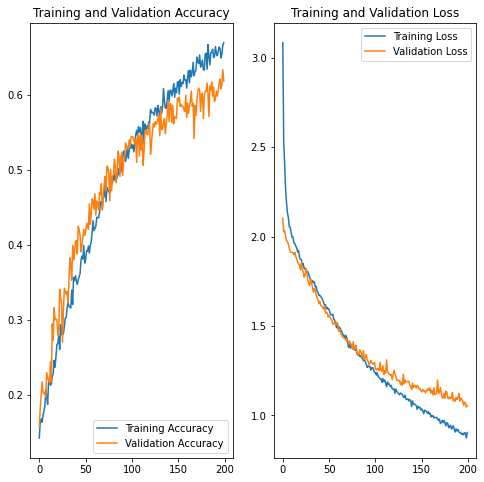

In [ ]:
import matplotlib.pyplot as plt
acc = cnnhistory1.history['accuracy']
val_acc = cnnhistory1.history['val_accuracy']

loss = cnnhistory1.history['loss']
val_loss = cnnhistory1.history['val_loss']
epochs=200
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
cnnhistory3=model.fit(x_traincnn, y_train, batch_size=32, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
54/54 [==============================] - 2s 28ms/step - loss: 1.6124 - accuracy: 0.4211 - val_loss: 1.4141 - val_accuracy: 0.4627
Epoch 2/200
54/54 [==============================] - 1s 24ms/step - loss: 1.2643 - accuracy: 0.5160 - val_loss: 1.3710 - val_accuracy: 0.4545
Epoch 3/200
54/54 [==============================] - 1s 24ms/step - loss: 1.2172 - accuracy: 0.5259 - val_loss: 1.3137 - val_accuracy: 0.4980
Epoch 4/200
54/54 [==============================] - 1s 24ms/step - loss: 1.1319 - accuracy: 0.5713 - val_loss: 1.2093 - val_accuracy: 0.5495
Epoch 5/200
54/54 [==============================] - 1s 25ms/step - loss: 1.1683 - accuracy: 0.5440 - val_loss: 1.2639 - val_accuracy: 0.5441
Epoch 6/200
54/54 [==============================] - 1s 25ms/step - loss: 1.0864 - accuracy: 0.6075 - val_loss: 1.3446 - val_accuracy: 0.5034
Epoch 7/200
54/54 [==============================] - 1s 24ms/step - loss: 1.0517 - accuracy: 0.6040 - val_loss: 1.2137 - val_accuracy: 0.5658
Epoch 

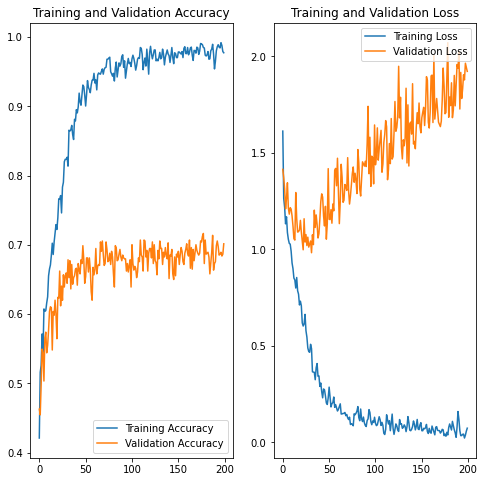

In [ ]:
import matplotlib.pyplot as plt
acc = cnnhistory3.history['accuracy']
val_acc = cnnhistory3.history['val_accuracy']

loss = cnnhistory3.history['loss']
val_loss = cnnhistory3.history['val_loss']
epochs=200
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()